In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# new benchmark, n=2, c0 = 1, c1 = VAR, a=3

In [84]:
alpha = 3.
c1s   = np.arange(1, 3.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [85]:
def F(c, x):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(costs))])
    return np.sum(vals)

In [86]:
def F1(c, x):
    return c * np.power(x, 1+1/alpha)

In [87]:
def theos(costs):
    den = np.sum([np.power(costs[i], -alpha) for i in range(len(costs))])
    return [np.power(costs[i], -alpha) / den for i in range(len(costs))]

In [88]:
xStars  = []
xStars2 = []
fStars  = []
fHats   = []
for c1 in c1s:
    costs  = [1, c1]
    xStar = theos(costs)
    xStars.append(xStar)
    fStars.append(F(costs, xStar))

    if xStar[0] > 2/3:
        xStars2.append([2/3, 1/3])
        fHats.append(F(costs, [2/3,1/3]))
    else:
        xStars2.append(xStar)
        fHats.append(F(costs, xStar))
xStars = np.asarray(xStars)
xStars2 = np.asarray(xStars2)
xStars.shape, xStars2.shape

((21, 2), (21, 2))

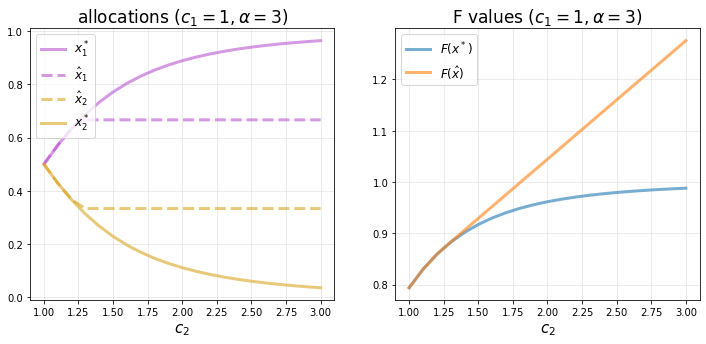

In [89]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xStars[:,0], linewidth=3, alpha=0.6, label=r'$x^*_1$', color='mediumorchid',
              linestyle='-')
axarr[0].plot(c1s, xStars2[:,0], linewidth=3, alpha=0.6, label=r'$\hat{x}_1$', color='mediumorchid',
              linestyle='--')
axarr[0].plot(c1s, xStars2[:,1], linewidth=3, alpha=0.6, label=r'$\hat{x}_2$', color='goldenrod',
              linestyle='--')
axarr[0].plot(c1s, xStars[:,1], linewidth=3, alpha=0.6, label=r'$x^*_2$', color='goldenrod',
              linestyle='-')

axarr[1].plot(c1s, fStars, linewidth=3, alpha=0.6, label=r'$F(x^*)$')
axarr[1].plot(c1s, fHats, linewidth=3, alpha=0.6, label=r'$F(\hat{x})$')

for ax in axarr:
    ax.legend(prop={'size': 12})
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'F values $(c_1=1, \alpha=3)$', size=17)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [90]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [91]:
guesses = c1s

In [92]:
xTildes = []
fTildes = []
f1s     = []
f2s     = []
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)

    xTildes.append(xTilde)
    fTildes.append(F(costs, xTilde))
    f1s.append(F1(costs[0], xTilde[0]))
    f2s.append(F1(costs[1], xTilde[1]))
fTildes = np.asarray(fTildes)
xTildes = np.asarray(xTildes)
f1s, f2s = np.asarray(f1s), np.asarray(f2s)
fTildes.shape, xTildes.shape

((21,), (21, 2))

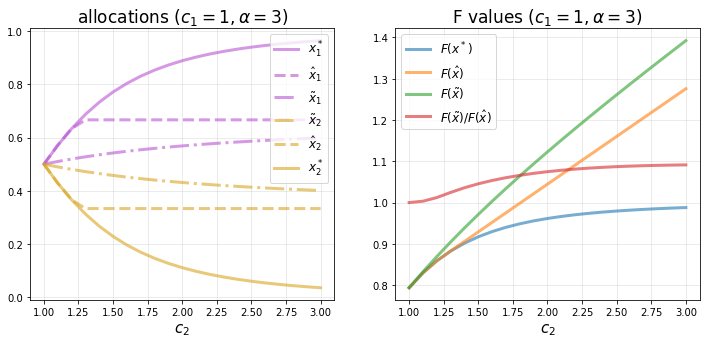

In [93]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xStars[:,0], linewidth=3, alpha=0.6, label=r'$x^*_1$', color='mediumorchid',
              linestyle='-')
axarr[0].plot(c1s, xStars2[:,0], linewidth=3, alpha=0.6, label=r'$\hat{x}_1$', color='mediumorchid',
              linestyle='--')
axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
axarr[0].plot(c1s, xStars2[:,1], linewidth=3, alpha=0.6, label=r'$\hat{x}_2$', color='goldenrod',
              linestyle='--')
axarr[0].plot(c1s, xStars[:,1], linewidth=3, alpha=0.6, label=r'$x^*_2$', color='goldenrod',
              linestyle='-')

axarr[1].plot(c1s, fStars, linewidth=3, alpha=0.6, label=r'$F(x^*)$')
axarr[1].plot(c1s, fHats, linewidth=3, alpha=0.6, label=r'$F(\hat{x})$')
axarr[1].plot(c1s, fTildes, linewidth=3, alpha=0.6, label=r'$F(\tilde{x})$')
axarr[1].plot(c1s, fTildes/fHats, linewidth=3, alpha=0.6, label=r'$F(\tilde{x})/F(\hat{x})$')

for ax in axarr:
    ax.legend(prop={'size': 12})
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'F values $(c_1=1, \alpha=3)$', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# new utility function

In [94]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [bs[i]*xs[i]-cs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [96]:
alpha = 3.
c1s   = np.arange(1, 2.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [102]:
xTildes = []
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
xTildes = np.asarray(xTildes)

[-2.125 -2.125]
[1.959375 1.959375]
[8.69999999 8.70000001]
[41.92500017 41.92499983]
[-11.72499907 -11.72500093]
[-21.93750053 -21.93749947]
[-13.40000025 -13.39999975]
[-14.23749989 -14.23750011]
[-9.44999993 -9.45000007]
[120.6499983 120.6500017]
[-16.7499988 -16.7500012]


/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [99]:
xTildes

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.49999999, 0.50000001],
       [0.50000012, 0.49999988],
       [0.49999996, 0.50000004],
       [0.49999997, 0.50000003],
       [0.50000001, 0.49999999],
       [0.50000001, 0.49999999],
       [0.50000002, 0.49999998],
       [0.50000011, 0.49999989]])

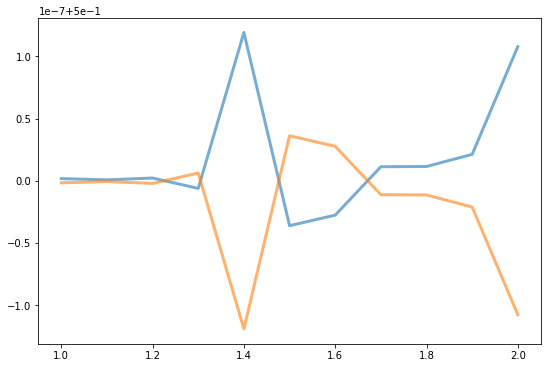

In [98]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$')
ax.plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$')

# ax.set_xlabel(r'$c_2$', size=15)
# ax.set_title(r'$c_1=1, \alpha=3$', size=17)
# ax.legend(prop={'size': 14})
# ax.grid(alpha=0.3)
# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [105]:
# true costs
c1, c2 = 1, 10

# init conditions
curr1, curr2 = 1, 10
a = 3

# symbols
b1 = sp.Symbol('b1', positive=True)
b2 = sp.Symbol('b2', positive=True)

p1Bids11, p2Bids11 = [curr1], [curr2]
turn = 0
for turn in tqdm(range(30)):
    if turn % 2 == 0:
        x1 = 1/(b1**a) / (1/(b1**a) + 1/(b2**a))
        u1 = b1*x1 - c1
        partial = sp.diff(u1, b1)
        best = sp.Eq(partial, 0).evalf(subs={b2:curr2})
        sol = sp.solve(best)[0]
        curr1 = sol
        p1Bids11.append(curr1)
    else:
        x2 = 1/(b2**a) / (1/(b1**a) + 1/(b2**a))
        u2 = b2*x2 - c2
        partial = sp.diff(u2, b2)
        best = sp.Eq(partial, 0).evalf(subs={b1:curr1})
        sol = sp.solve(best)[0]
        curr2 = sol
        p2Bids11.append(curr2)

100%|██████████| 30/30 [00:02<00:00, 11.26it/s]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


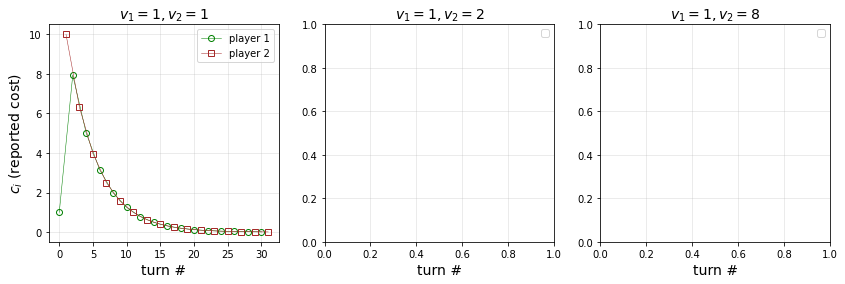

In [106]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))


axarr[0].plot(np.arange(0,31,2), p1Bids11, marker='o', fillstyle='none',
              linewidth=0.5, color='green', label='player 1')
axarr[0].plot(np.arange(1,32,2), p2Bids11, marker='s', fillstyle='none', 
              linewidth=0.5, color='brown', label='player 2')

# axarr[1].plot(np.arange(0,31,2), p1Bids12, marker='o', fillstyle='none',
#               linewidth=0.5, color='green', label='player 1')
# axarr[1].plot(np.arange(1,32,2), p2Bids12, marker='s', fillstyle='none', 
#               linewidth=0.5, color='brown', label='player 2')

# axarr[2].plot(np.arange(0,31,2), p1Bids18, marker='o', fillstyle='none',
#               linewidth=0.5, color='green', label='player 1')
# axarr[2].plot(np.arange(1,32,2), p2Bids18, marker='s', fillstyle='none', 
#               linewidth=0.5, color='brown', label='player 2')

axarr[0].set_title(r'$v_1=1,v_2=1$', size=14)
axarr[1].set_title(r'$v_1=1,v_2=2$', size=14)
axarr[2].set_title(r'$v_1=1,v_2=8$', size=14)
axarr[0].set_ylabel(r'$c_i$ (reported cost)', size=14)
for ax in axarr:
    ax.set_xlabel(r'turn #', size=14)
    ax.grid(alpha=0.3)
    ax.legend()

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()